## Business Objective 2

Segregate crime data and identify patterns and draw inferences.  

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np

In [5]:
sns.set()

### Data Dictionary

In [6]:
crime = pd.read_csv('crime_data (1).csv')

### Exploratory Data Analysis

In [7]:
crime.sample(5)

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
16,Kentucky,9.7,109,52,16.3
14,Iowa,2.2,56,57,11.3
7,Delaware,5.9,238,72,15.8
13,Indiana,7.2,113,65,21.0
43,Utah,3.2,120,80,22.9


In [8]:
crime.rename(columns = {'Unnamed: 0':'City'}, inplace = True)

In [9]:
crime.columns

Index(['City', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [10]:
crime.shape

(50, 5)

In [11]:
crime.dtypes

City         object
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

In [12]:
crime.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [13]:
crime.duplicated().sum()

0

Imputation not needed

#### Univariate analysis

##### Moments

In [14]:
crime.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


* We can see that the mean has varied range. We would want to Standardize the data.   
* We observe that assault cases are maximum followed by urbanpop among all cities.

In [15]:
#Fisher's Kurtosis
crime.kurtosis(numeric_only=True)

Murder     -0.827488
Assault    -1.053848
UrbanPop   -0.738360
Rape        0.353964
dtype: float64

all are platykurtic

In [16]:
#skew
crime.skew(numeric_only=True)

Murder      0.393956
Assault     0.234410
UrbanPop   -0.226009
Rape        0.801200
dtype: float64

##### Distributions

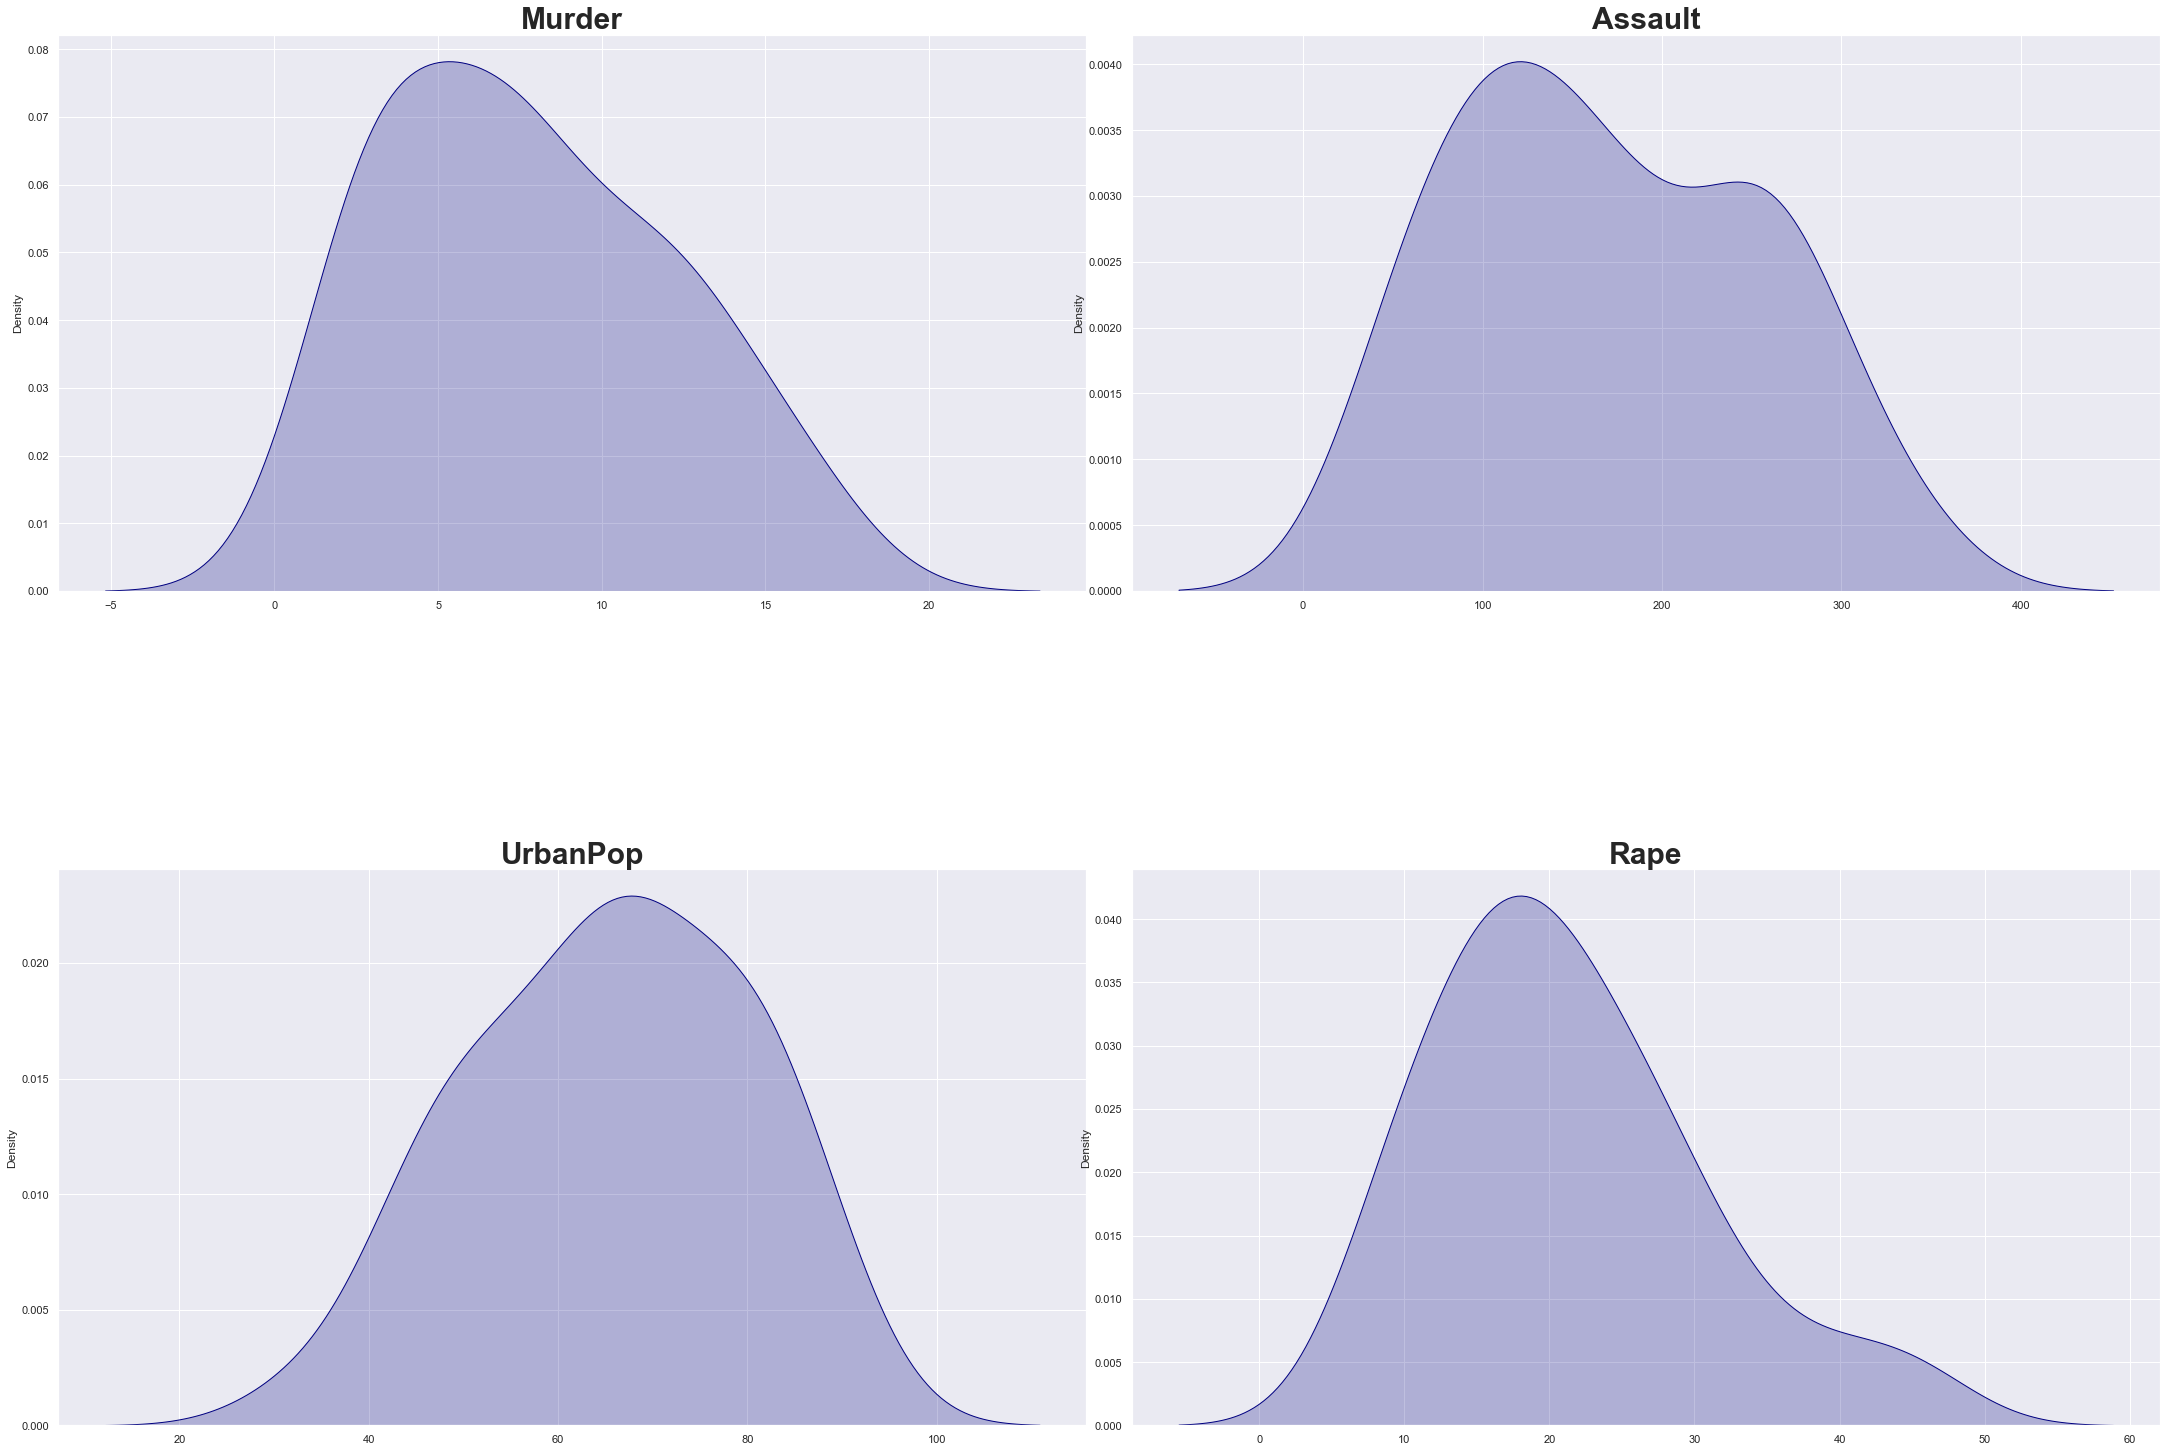

In [17]:
#display distributions for numeric data
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(30,20))
fig.tight_layout()
cols = ['Murder','Assault','UrbanPop','Rape']
axeslist = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
j=0
for col in cols:
    p= sns.kdeplot(data=crime, ax=axeslist[j] ,x=col,fill=True,color="navy")
    p.set(xlabel=None)
    fig.subplots_adjust(hspace=0.5)
    axeslist[j].set_title(col,fontweight="bold", size=30)
    j= j+1

**Observations:**  
    * rape and murder are right skewed  
    * all are leptokurtic.
    * assault is bimodal  
    * Let's check the QQ plot for these columns

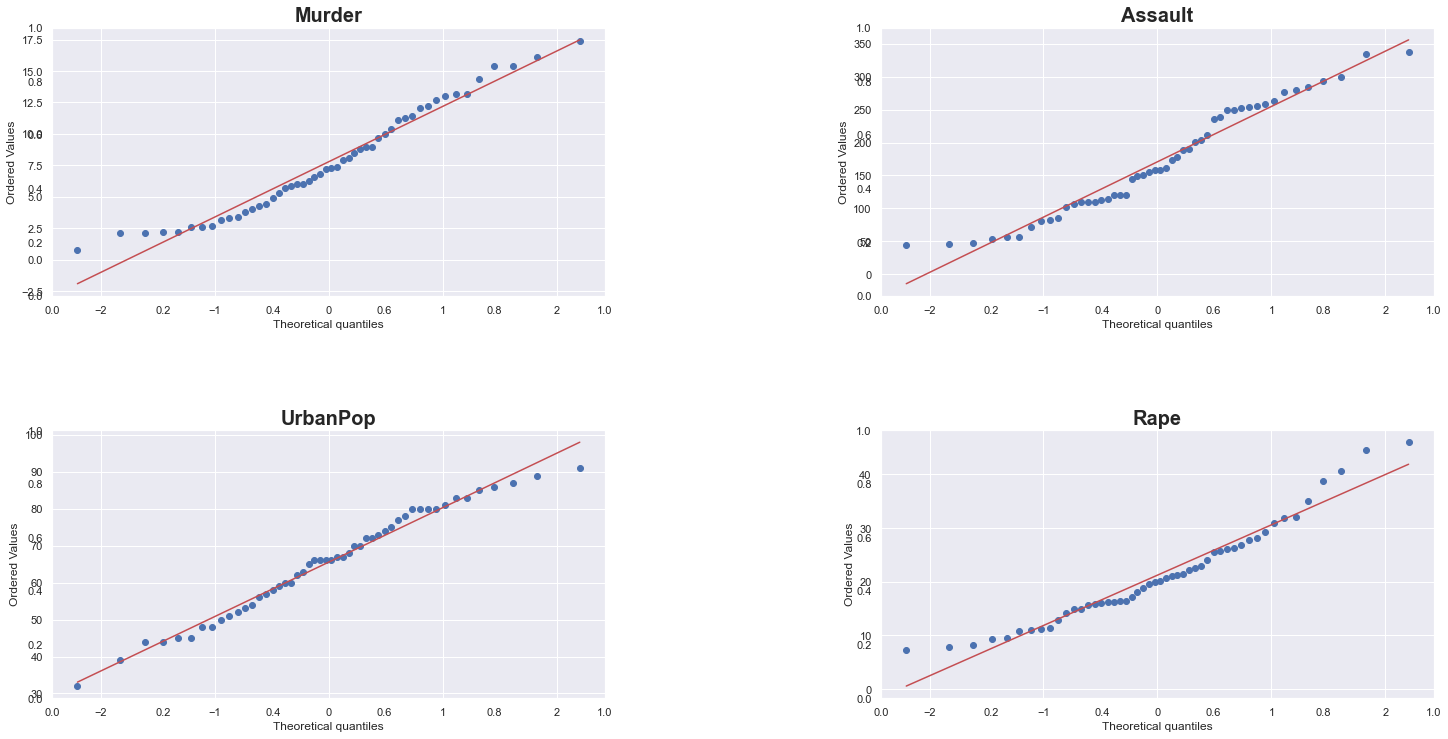

In [18]:
#Review QQ Plot for other normally distributed columns
import scipy.stats as stats
import pylab
cols = ['Murder','Assault','UrbanPop','Rape']
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(20,10))
fig.tight_layout()
nfig = [1,2,3,4]
j=0

for col in cols:
    ax = fig.add_subplot(2, 2, nfig[j])
    p=stats.probplot(crime[col], dist="norm", plot=ax)
    ax.set_title(col,fontweight="bold", size=20)
    fig.subplots_adjust(wspace=0.5)
    fig.subplots_adjust(hspace=0.5)
    j= j+1


**Observations:**  
    * All columns are almost normally distributed . assault and rape are slightly non gaussian.  
    * We will apply 'yeo-johnson' PowerTransformer on the non gaussian features (assault,rape) when we create pipeline. 

In [19]:
from scipy.stats import shapiro
def shapiroWilkTest(df):
    # create an Empty DataFrame object
    scorecard = pd.DataFrame()
    alpha = 0.05
    clm= []
    stat1=[]
    p1=[]
    dist=[]
    j=0
    for c in df.columns:  
        stat, p = shapiro(df.iloc[:,j])
        clm.append(c)
        stat1.append(stat)
        p1.append(p)
        if p > alpha:
            dist.append('Gaussian') 
        else:
            dist.append('Not Gaussian')
        j=j+1
    scorecard['column'] = clm
    scorecard['stat'] = stat1
    scorecard['p'] = p1
    scorecard['Distribution'] = dist
    return scorecard

In [20]:
#Apply Shapiro-Wilk to test the null hypothesis that the data was drawn from a normal distribution.
shapiroWilkTest(crime.drop(['City'],axis=1))

,column,stat,p,Distribution
0,Murder,0.957027,0.066742,Gaussian
1,Assault,0.951815,0.040525,Not Gaussian
2,UrbanPop,0.977135,0.438460,Gaussian
3,Rape,0.946737,0.025097,Not Gaussian


##### Outlier Treatment

In [21]:
#split dataframe to get numeric data
crime_num = crime.drop(['City'],axis=1)

In [22]:
from sklearn.preprocessing import MinMaxScaler
#Normalize data to view boxplot
scalerMM = MinMaxScaler()
crime_num_norm= pd.DataFrame(scalerMM.fit_transform(crime_num))
crime_num_norm.columns=crime_num.columns


In [23]:
crime_num_norm.sample(4)

,Murder,Assault,UrbanPop,Rape
36,0.246988,0.390411,0.593220,0.568475
7,0.307229,0.660959,0.677966,0.219638
3,0.481928,0.496575,0.305085,0.315245
49,0.361446,0.397260,0.474576,0.214470


<AxesSubplot:>

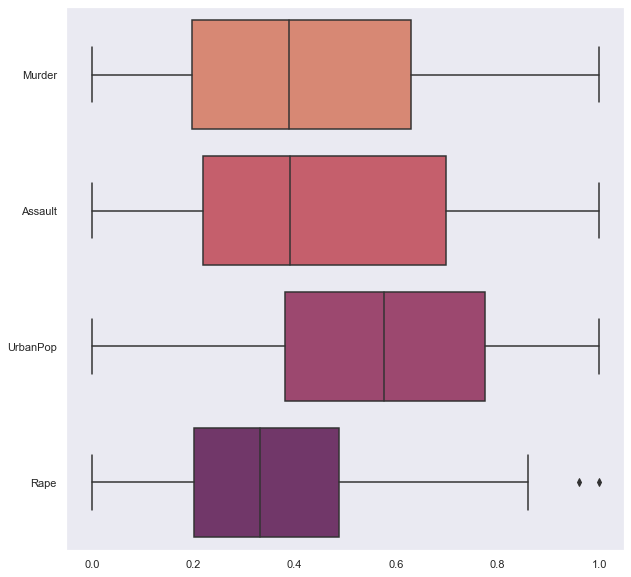

In [24]:
#View outliers for non Gaussian distributions
plt.figure(figsize=(10,10))
sns.set_style("dark")
sns.boxplot(data=crime_num_norm, orient="h", palette = 'flare')

In [25]:
#function to get outliers from all numeric features
def IQR_Outliers (X, features):
    
    Outlier_df = pd.DataFrame()
    ulimit=[]
    llimit=[]
    no_of_outliers =[]
    perc = []
    feature = []


    indices = [x for x in X.index]
    print('Number of samples: ', len(indices))
    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(X[col], 25.)
        Q3 = np.nanpercentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
        
        feature.append(col)        
        ulimit.append(upper)
        llimit.append(lower)
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        

        no_of_outliers.append(len(outliers))
        perc.append(round((len(outliers)*100)/len(indices),2))

        out_indexlist.extend(outliers_index)
    
    Outlier_df['feature'] = feature
    Outlier_df['no_of_outliers']= no_of_outliers 
    Outlier_df['percentage']= perc
    Outlier_df['upper_limit']= ulimit
    Outlier_df['lower_limit']= llimit
                   
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()
    print('\nNumber of rows with outliers: ', len(out_indexlist))
    return Outlier_df   


In [26]:
#get outliers from all numeric features
IQR_Outliers(crime, ['Murder', 'Assault', 'UrbanPop', 'Rape'])

Number of samples:  50

Number of rows with outliers:  2


,feature,no_of_outliers,percentage,upper_limit,lower_limit
0,Murder,0,0.0,22.0125,-6.6875
1,Assault,0,0.0,459.0000,-101.0000
2,UrbanPop,0,0.0,112.6250,19.6250
3,Rape,2,4.0,42.8250,-1.5750


In [27]:
crime.columns

Index(['City', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

We will consider only upper limit for the 2 outliers in Rape

We will author a custom Transformer to cap the outliers

In [28]:
from sklearn.base import BaseEstimator,TransformerMixin
class OutlierCapper(BaseEstimator,TransformerMixin):
    #def __init__(self,factor=1.5):
        #self.factor = factor
        
        
    def outlier_cap(self,X,y=None):
        print(X)
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        X.loc[(X < lower_bound)] = lower_bound 
        X.loc[(X > upper_bound)] = upper_bound 
        return pd.Series(X)
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.apply(self.outlier_cap)
    
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [29]:
crime.shape

(50, 5)

In [30]:
from sklearn.compose import ColumnTransformer
numeric_features = ['Murder','Assault','UrbanPop','Rape']
outlierTreatment = ColumnTransformer([
    ('outlier_capper',OutlierCapper(),numeric_features)],remainder='passthrough')


In [31]:
data_without_outliers = pd.DataFrame(outlierTreatment.fit_transform(crime),columns=['Murder','Assault','UrbanPop','Rape','City'])

0     13.2
1     10.0
2      8.1
3      8.8
4      9.0
5      7.9
6      3.3
7      5.9
8     15.4
9     17.4
10     5.3
11     2.6
12    10.4
13     7.2
14     2.2
15     6.0
16     9.7
17    15.4
18     2.1
19    11.3
20     4.4
21    12.1
22     2.7
23    16.1
24     9.0
25     6.0
26     4.3
27    12.2
28     2.1
29     7.4
30    11.4
31    11.1
32    13.0
33     0.8
34     7.3
35     6.6
36     4.9
37     6.3
38     3.4
39    14.4
40     3.8
41    13.2
42    12.7
43     3.2
44     2.2
45     8.5
46     4.0
47     5.7
48     2.6
49     6.8
Name: Murder, dtype: float64
0     236
1     263
2     294
3     190
4     276
5     204
6     110
7     238
8     335
9     211
10     46
11    120
12    249
13    113
14     56
15    115
16    109
17    249
18     83
19    300
20    149
21    255
22     72
23    259
24    178
25    109
26    102
27    252
28     57
29    159
30    285
31    254
32    337
33     45
34    120
35    151
36    159
37    106
38    174
39    279
40     86
41    188
4

In [32]:
data_without_outliers

,Murder,Assault,UrbanPop,Rape,City
0,13.2,236.0,58.0,21.2,Alabama
1,10.0,263.0,48.0,42.825,Alaska
2,8.1,294.0,80.0,31.0,Arizona
3,8.8,190.0,50.0,19.5,Arkansas
4,9.0,276.0,91.0,40.6,California
5,7.9,204.0,78.0,38.7,Colorado
6,3.3,110.0,77.0,11.1,Connecticut
7,5.9,238.0,72.0,15.8,Delaware
8,15.4,335.0,80.0,31.9,Florida
9,17.4,211.0,60.0,25.8,Georgia


In [33]:
data_without_outliers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Murder    50 non-null     object
 1   Assault   50 non-null     object
 2   UrbanPop  50 non-null     object
 3   Rape      50 non-null     object
 4   City      50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


In [34]:
data_without_outliers = data_without_outliers.infer_objects()

In [35]:
data_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     float64
 2   UrbanPop  50 non-null     float64
 3   Rape      50 non-null     float64
 4   City      50 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [36]:
IQR_Outliers(data_without_outliers.drop(['City'], axis=1), numeric_features)

Number of samples:  50

Number of rows with outliers:  0


,feature,no_of_outliers,percentage,upper_limit,lower_limit
0,Murder,0,0.0,22.0125,-6.6875
1,Assault,0,0.0,459.0000,-101.0000
2,UrbanPop,0,0.0,112.6250,19.6250
3,Rape,0,0.0,42.8250,-1.5750


In [37]:
data_without_outliers.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape', 'City'], dtype='object')

<AxesSubplot:>

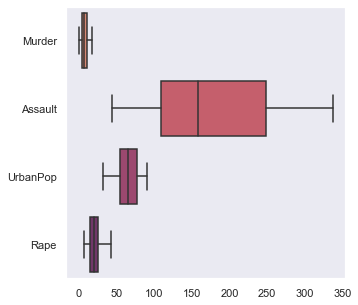

In [38]:
#View boxplot post outlier treatment
plt.figure(figsize=(5,5))
sns.set_style("dark")
df = pd.DataFrame(data = data_without_outliers, columns = ['Murder', 'Assault', 'UrbanPop', 'Rape'])
sns.boxplot(data=df, orient="h", palette = 'flare')

**Observations**  
* The outliers are replaced with the upper limits at 1.5 times IQR

### Multivariate Analysis

#### Pair-wise Scatter Plots

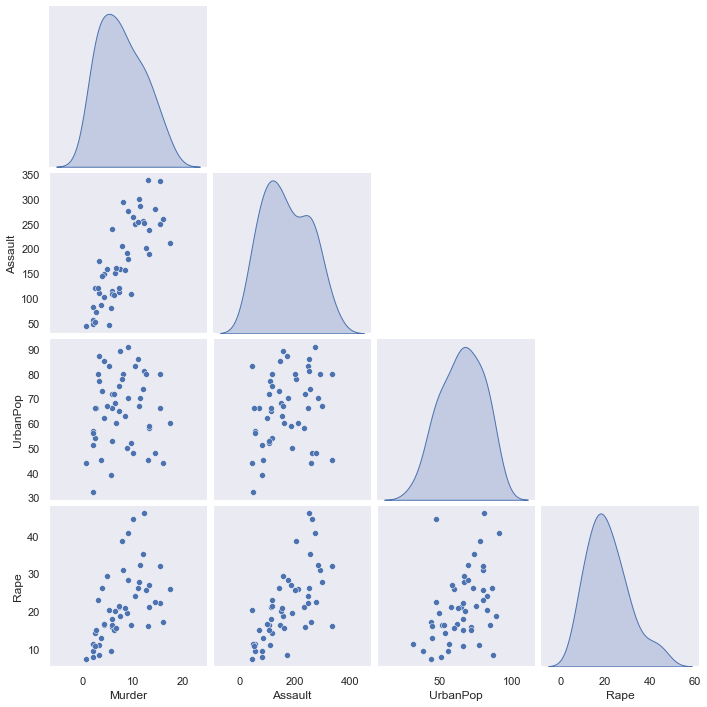

In [39]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 30,20
sns.pairplot(crime.drop(['City'],axis=1),diag_kind="kde", diag_kws=dict(shade=True),corner=True)
#fig.suptitle('Airline Attributes Pairwise Plots', fontsize=14)

**Observations**  
* Rape seems to have  a linear relationship  with all other crimes  
* Assault has a linear relasionship with murder  

#### Triangular Heat Map

<AxesSubplot:>

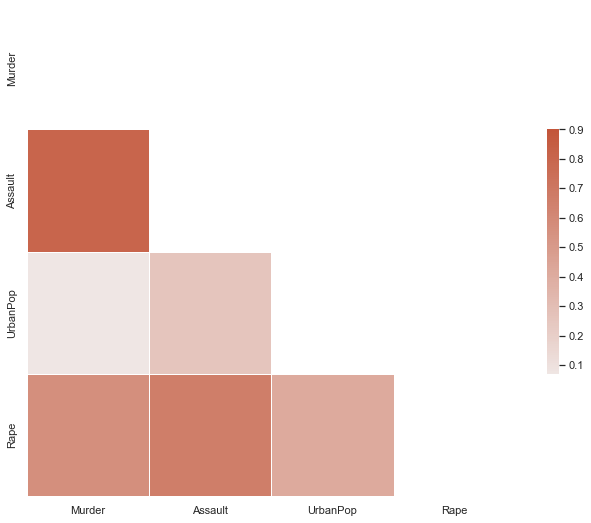

In [40]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(crime.corr(), dtype=bool))

corr= crime.corr(method ='pearson')

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Correlation matrix

In [41]:
crime.corr(method ='pearson')

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


**Observations**  
* Assault and murder have very high correlation    
* Assault and rape have  high correlation    

In [42]:
#Get only highly correlated items

df = crime.corr().abs().round(1)
df = crime.corr().round(1)
for column in df:
    ac = df[column].round(1)
    replace_col = df[((ac < 0.5) & (ac >= 0))| ((ac > -0.5) & (ac <= 0))].index
    df.at[replace_col, column]='blah'
df

,Murder,Assault,UrbanPop,Rape
Murder,1.0,0.8,blah,0.6
Assault,0.8,1.0,blah,0.7
UrbanPop,blah,blah,1.0,blah
Rape,0.6,0.7,blah,1.0


**Observations**  
* Assault and murder have very high correlation    
* Assault and rape have  high correlation 
* murder and rape have  high correlation

### Data Preprocessing

In [43]:
# Scaling - Standardize the numerical variables 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer



outlierTreatment = ColumnTransformer([
    ('outlier_capper',OutlierCapper(),slice(3,4))],remainder='passthrough')

yeojohnson = ColumnTransformer([
    ('ptransform',PowerTransformer(method='yeo-johnson', standardize=False), [1,3])],remainder='passthrough')

scaling = ColumnTransformer([
    ('scale',StandardScaler(), slice(1,5))],remainder='passthrough')


### Create Pipeline

In [44]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('outlierTreatment',outlierTreatment),
    ('yeojohnson',yeojohnson),
    ('scaling',scaling)
])

In [45]:
crime_num= crime.drop(['City'],axis=1)

In [46]:
crime_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 1.7 KB


In [47]:
# Apply the tranformation
crime_transformed = pipe.fit_transform(crime_num) 

0     21.2
1     44.5
2     31.0
3     19.5
4     40.6
5     38.7
6     11.1
7     15.8
8     31.9
9     25.8
10    20.2
11    14.2
12    24.0
13    21.0
14    11.3
15    18.0
16    16.3
17    22.2
18     7.8
19    27.8
20    16.3
21    35.1
22    14.9
23    17.1
24    28.2
25    16.4
26    16.5
27    46.0
28     9.5
29    18.8
30    32.1
31    26.1
32    16.1
33     7.3
34    21.4
35    20.0
36    29.3
37    14.9
38     8.3
39    22.5
40    12.8
41    26.9
42    25.5
43    22.9
44    11.2
45    20.7
46    26.2
47     9.3
48    10.8
49    15.6
Name: Rape, dtype: float64


In [48]:
crime_transformed[1,:]

array([-1.21727143,  2.40232482,  1.11805959,  4.10432175])

In [49]:
#verify shape remains same after tranformation
tuple(map(lambda i, j: i - j, crime_num.shape, crime_transformed.shape))

(0, 0)

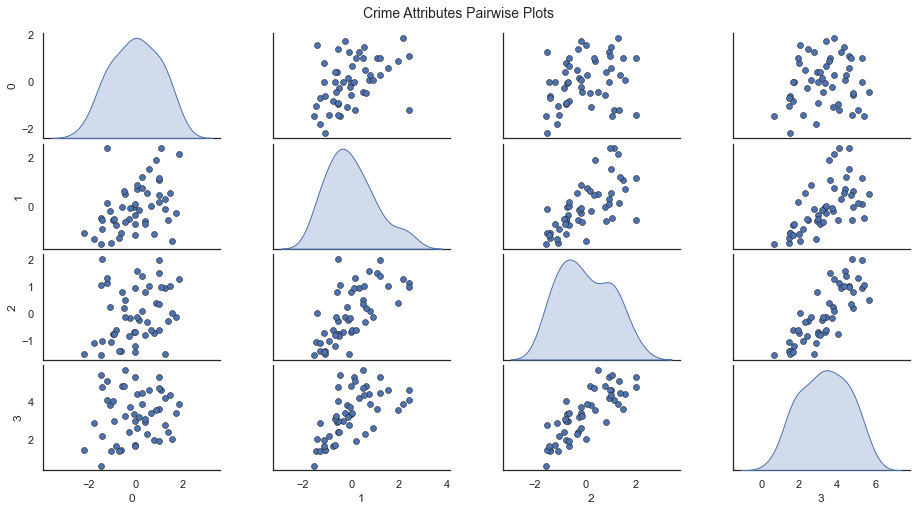

In [50]:
# Pair-wise Scatter Plots
wt = pd.DataFrame(crime_transformed)
pp = sns.pairplot(wt, height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Crime Attributes Pairwise Plots', fontsize=14)

In [51]:
# View Tranformation steps
pipe.named_steps

{'outlierTreatment': ColumnTransformer(remainder='passthrough',
                   transformers=[('outlier_capper', OutlierCapper(),
                                  slice(3, 4, None))]),
 'yeojohnson': ColumnTransformer(remainder='passthrough',
                   transformers=[('ptransform',
                                  PowerTransformer(standardize=False), [1, 3])]),
 'scaling': ColumnTransformer(remainder='passthrough',
                   transformers=[('scale', StandardScaler(), slice(1, 5, None))])}

### Model Building

#### K Means Clustering

##### Evaluate k with Elbow Graph

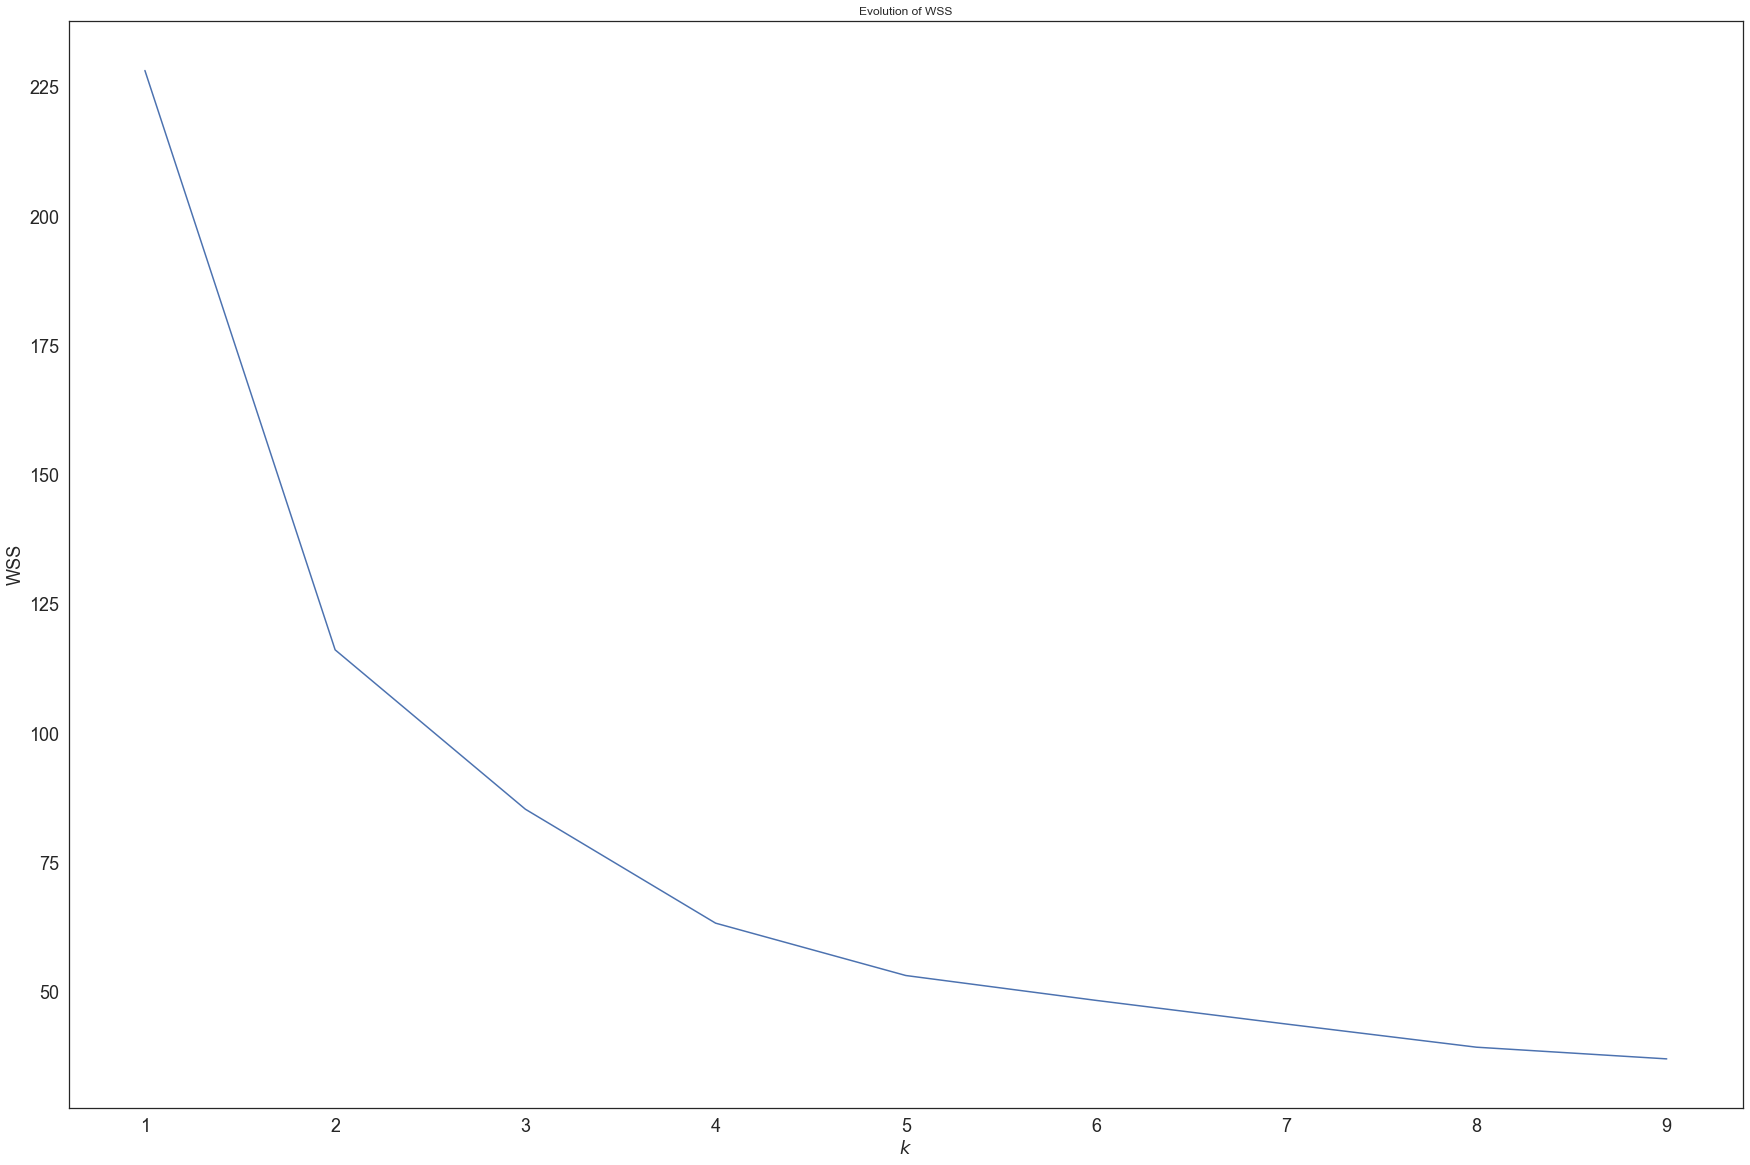

In [52]:
from sklearn.cluster import KMeans

inertia = []
k = range(1,10)
for iter in k:
    kmeans = KMeans(init = 'k-means++',n_clusters=iter, random_state=2)
    kmeans.fit(crime_transformed)
    y_kmeans = kmeans.predict(crime_transformed)
    centers = kmeans.cluster_centers_
    inertia.append(kmeans.inertia_ ) # we already store this for later, inertia=WSS

plt.figure()
plt.title("Evolution of WSS")
plt.plot(k, inertia)
plt.ylabel("WSS",fontsize=18)
plt.xlabel("$k$",fontsize=18)
plt.xticks(k,fontsize=18)
plt.yticks(fontsize=18)
plt.show()

##### Apply K Means clustering

In [59]:
kmeans = KMeans(init = 'k-means++' ,n_clusters=2, random_state=2)
kmeans.fit(crime_transformed)
labels_ = kmeans.predict(crime_transformed)

In [60]:
# Data points spread
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0])

In [61]:
# Data points count per label
unique, counts = np.unique(labels_, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 30],
       [ 1, 20]], dtype=int64)

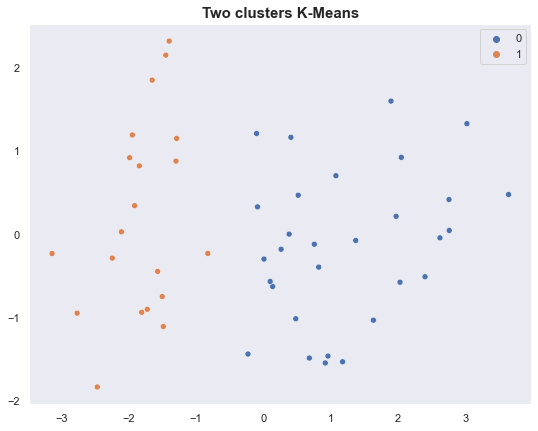

In [62]:
from sklearn import decomposition
# Transform data to visualize data in 2d
sns.set_style('dark')
pca = decomposition.PCA(n_components=3)
crime_pca = pca.fit_transform(crime_transformed)
plt.figure(figsize=(9,7))
sns.scatterplot(hue=kmeans.labels_, x=crime_pca[:,0], y=crime_pca[:,1],palette="deep")
plt.title("Two clusters K-Means",fontsize=15,fontweight="bold")
plt.show()

### Benefits/impact of the solution 

In [64]:
#Link the clusters to original data

cluster_labels = pd.Series(kmeans.labels_)
crime['cluster'] = cluster_labels # creating a new column and assigning it to new column

In [65]:
crime

,City,Murder,Assault,UrbanPop,Rape,cluster
0,Alabama,13.2,236,58,21.2,1
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
3,Arkansas,8.8,190,50,19.5,0
4,California,9.0,276,91,40.6,1
5,Colorado,7.9,204,78,38.7,1
6,Connecticut,3.3,110,77,11.1,0
7,Delaware,5.9,238,72,15.8,0
8,Florida,15.4,335,80,31.9,1
9,Georgia,17.4,211,60,25.8,1


In [66]:
crime.groupby('cluster').size()

cluster
0    30
1    20
dtype: int64

In [67]:
#airline1.groupby('cluster', as_index=False)['Bonus_trans','Bonus_miles'].mean()
crime.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,4.870,114.433333,63.633333,15.943333
1,12.165,255.250000,68.400000,29.165000


In [72]:
crime[crime['cluster']==1]

,City,Murder,Assault,UrbanPop,Rape,cluster
0,Alabama,13.2,236,58,21.2,1
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
4,California,9.0,276,91,40.6,1
5,Colorado,7.9,204,78,38.7,1
8,Florida,15.4,335,80,31.9,1
9,Georgia,17.4,211,60,25.8,1
12,Illinois,10.4,249,83,24.0,1
17,Louisiana,15.4,249,66,22.2,1
19,Maryland,11.3,300,67,27.8,1


* Observe higher murder rates in the above group. 
* Overall crime rates are on the higher side compared to other cities.
* We need to enhance policing on priority basis in the  above cities


In [73]:
crime[crime['cluster']==1].sort_values(by=['Assault', 'Murder','Rape'],ascending=False)

,City,Murder,Assault,UrbanPop,Rape,cluster
32,North Carolina,13.0,337,45,16.1,1
8,Florida,15.4,335,80,31.9,1
19,Maryland,11.3,300,67,27.8,1
2,Arizona,8.1,294,80,31.0,1
30,New Mexico,11.4,285,70,32.1,1
39,South Carolina,14.4,279,48,22.5,1
4,California,9.0,276,91,40.6,1
1,Alaska,10.0,263,48,44.5,1
23,Mississippi,16.1,259,44,17.1,1
21,Michigan,12.1,255,74,35.1,1


In [74]:
crime[crime['cluster']==0].sort_values(by=['Assault', 'Murder','Rape'])

,City,Murder,Assault,UrbanPop,Rape,cluster
33,North Dakota,0.8,45,44,7.3,0
10,Hawaii,5.3,46,83,20.2,0
44,Vermont,2.2,48,32,11.2,0
48,Wisconsin,2.6,53,66,10.8,0
14,Iowa,2.2,56,57,11.3,0
28,New Hampshire,2.1,57,56,9.5,0
22,Minnesota,2.7,72,66,14.9,0
47,West Virginia,5.7,81,39,9.3,0
18,Maine,2.1,83,51,7.8,0
40,South Dakota,3.8,86,45,12.8,0


* Observe lower crime rates in the above cities. 